Also requires `jupyter labextension install jupyterlab-plotly`

In [1]:
from requests import get
import requests_cache
import geopandas
from pathlib import Path
import zipfile
from io import BytesIO
import tempfile
import pandas as pd
import numpy as np

In [2]:
import plotly.figure_factory as ff
import plotly.io as pio
import plotly as plt
pio.renderers.default = "jupyterlab"

Unclear what year or source this plotly dataset is from, but it provides an easy form of geo boundary for plotting

In [3]:
df_map = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/minoritymajority.csv')

In [4]:
GA_map = df_map[df_map['STNAME']=='Georgia']

In [17]:
county_order = GA_map['CTYNAME'].to_list()
counties_norm = [c.split()[0] for c in county_order]

In [157]:
"Ben Hill County" in county_order

True

In [22]:
GA_map = GA_map.assign(County=counties_norm)

In [10]:
demo_df_metadata = pd.read_csv('../Data/Clean Demographic Data File - Dictionary.csv')

In [38]:
demo_df_metadata.iloc[93]['Source']

'https://www.cdc.gov/healthyschools/dataandstatistics.htm'

In [15]:
demo_df = pd.read_csv('../Data/Clean Demographic Data File.csv')

In [16]:
demo_df.head()

,State,County,Longitude,Lat,HOUSEHOLDS WITH INTERNET ACCESS (2014-2018),HYPERTIONSION DIAGNOSIS IN ADULTS (2017),HEART DISEASE DIAGNOSIS IN ADULTS (2017),DIABETES DIAGNOSIS FOR ADULTS (2017),HIGH CHOLESTEROL DIAGNOSIS IN ADULTS (2017),"CANCER INCIDENCE PER 100,000 PEOPLE (2011-2015)",...,Current Smokers (Persons 18 Years and Over),Drinking Adults (Persons 18 Years and Over),Persons with Limited Access to Healthy Foods,Persons with Access to Exercise Opportunities,Obese Persons (20 Years and Over),Physically Inactive Persons (20 Years and Over),Children Eligible for Free Lunch (Persons < 18 Years),Teen Births (Females 15 to 19 Years),Premature Deaths (Less than 75 Years),"Rate of limited-service restaurants per 100,000 people in 2017."
0,Georgia,Clayton,-84.355942,33.541872,82.29,34.0,2.9,11.1,26.0,458.1,...,19.8%,12.6%,14.3%,82.5%,39.5%,26.0%,79.1%,"3,514","2,614",73.56
1,Georgia,DeKalb,-84.223960,33.769440,87.02,33.0,3.1,10.7,26.7,447.1,...,14.3%,16.6%,8.5%,96.2%,26.5%,21.1%,64.3%,"6,336","6,694",84.90
2,Georgia,Hancock,-82.997669,33.272157,51.79,43.4,4.7,15.9,32.4,357.2,...,20.9%,11.1%,18.0%,0.2%,36.0%,29.5%,64.2%,85,137,70.30
3,Georgia,Dougherty,-84.217224,31.533285,75.98,37.4,3.9,12.7,28.6,489.0,...,21.0%,11.6%,20.6%,70.7%,37.0%,29.1%,76.7%,"1,838","1,489",109.83
4,Georgia,Richmond,-82.070264,33.357771,77.12,35.1,3.7,12.1,28.1,448.9,...,20.1%,13.9%,12.5%,62.6%,35.1%,27.9%,71.5%,"2,840","3,150",91.33


In [30]:
demo_df = demo_df.set_index('County')
GA_map = GA_map.set_index('County')

In [33]:
GA_map = GA_map.join(demo_df, how='inner', on='County')

In [128]:
list(GA_map.columns)

['FIPS',
 'STNAME',
 'CTYNAME',
 'TOT_POP',
 'TOT_MALE',
 'TOT_FEMALE',
 'WA_MALE',
 'WA_FEMALE',
 'NHWA_MALE',
 'NHWA_FEMALE',
 'NHWhite_Alone',
 'Not_NHWhite_Alone',
 'MinorityMinority',
 'MinorityPCT',
 'Black',
 'BlackPCT',
 'Hispanic',
 'HispanicPCT',
 'State',
 'Longitude',
 'Lat',
 'HOUSEHOLDS WITH INTERNET ACCESS (2014-2018)',
 'HYPERTIONSION DIAGNOSIS IN ADULTS (2017)',
 'HEART DISEASE DIAGNOSIS IN ADULTS (2017)',
 'DIABETES DIAGNOSIS FOR ADULTS (2017)',
 'HIGH CHOLESTEROL DIAGNOSIS IN ADULTS (2017)',
 'CANCER INCIDENCE PER 100,000 PEOPLE (2011-2015)',
 'DEPRESSION DIAGNOSIS RATE (2017)',
 'HIV DIAGNOSIS RATE (2016)',
 'RELIGIOUS ADHERENCE RATE (2010)',
 'VOTING AGE POPULATION TURNOUT RATE IN 2016 GENERAL ELECTION',
 'PERCENTAGE VOTE FOR A DEMOCRAT IN 2016 SENATE ELECTION ',
 'PERCENTAGE VOTE FOR A REPUBLICAN IN 2016 SENATE ELECTION ',
 'TOTAL POPULATION RATE (ACS 2014-2018)',
 'TOTAL POPULATION MALE (ACS 2014-2018)',
 'TOTAL POPULATION FEMALE (ACS 2014-2018)',
 'Under 5 Years

In [116]:
def trans_percent(s: str) -> float:
    return float(s[:-1])

def trans_number_with_commas(s: str) -> float:
    return float(s.replace(',',''))

def transform(col_name, missing_fill=np.nan):
    col_data = GA_map[col_name].tolist()
    is_pc = any([isinstance(d, str) and d[-1] == '%' for d in col_data])
    if is_pc:
        tf = trans_percent
    else:
        # assume float
        tf = trans_number_with_commas
    return [tf(s) if isinstance(s, str) else missing_fill for s in GA_map[col_name]]    

In [153]:
def make_plot(fips, values, num_bins, title):
    endpts = list(np.mgrid[min(values):max(values):(num_bins+1)*1j])
    fig = ff.create_choropleth(
        fips=fips, values=values, scope=['Georgia'], show_state_data=True,
        #colorscale="Reds", #colorscale,
        binning_endpoints=endpts, round_legend_values=True,
        plot_bgcolor='rgb(229,229,229)',
        paper_bgcolor='rgb(229,229,229)',
        legend_title=title,
        county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
        exponent_format=False,
    )
    fig.layout.template = None
    hover_ix, hover = [(ix, t) for ix, t in enumerate(fig['data']) if t.text][0]
    if len(hover['text']) != len(GA_map):
        # hack fixes to hovertext while waiting on Issue 1429 to be fixed
        # https://github.com/plotly/plotly.py/issues/1429#issuecomment-506925578
        ht = pd.Series(hover['text'])

        no_dupe_ix = ht.index[~ht.duplicated()]

        hover_x_deduped = np.array(hover['x'])[no_dupe_ix]
        hover_y_deduped = np.array(hover['y'])[no_dupe_ix]

        new_hover_x = [x if type(x) == float else x[0] for x in hover_x_deduped]
        new_hover_y = [y if type(y) == float else y[0] for y in hover_y_deduped]

        fig['data'][hover_ix]['text'] = ht.drop_duplicates()
        fig['data'][hover_ix]['x'] = new_hover_x
        fig['data'][hover_ix]['y'] = new_hover_y
    fig.show()

In [120]:
fips = GA_map['FIPS'].tolist() # Federal Information Processing Standard geographic location code

In [149]:
# sanity check, these ratios by county would all be = 100% if the data was precisely accurate and measured from the same time and source.
title = "Ratio of total population from two sources (%)"
values = 100 * np.array(transform('TOTAL POPULATION RATE (ACS 2014-2018)', 0)) / GA_map['TOT_POP'].values
num_bins = 8

In [167]:
col_name = 'Physically Inactive Persons (20 Years and Over)'
values = transform(col_name, np.nan)
title = col_name + " (%)"
num_bins = 4

In [165]:
title = col_name = 'Teen Births (Females 15 to 19 Years)' # absolute counts need normalizing
values = (np.array(transform(col_name, np.nan)) / GA_map['TOT_POP'].values) * 100
num_bins = 3

It's unclear so far why county regions for Ben Hill and Jeff Davis are empty. Is there an error in the downloaded dataset from plotly? There is data for them...

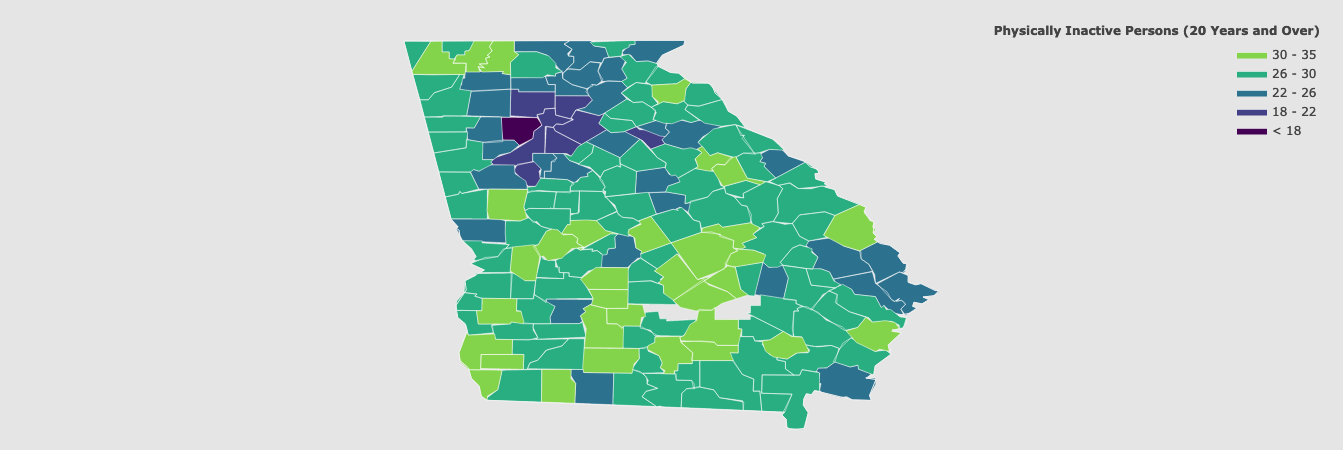

In [168]:
make_plot(fips, values, num_bins, title)

<br><hr><br>

Here is some alternative geo data sources for GA precincts and accompanying stats

In [17]:
urls = {
        "congress12": "http://www.legis.ga.gov/Joint/reapportionment/Documents/SEPT%202012/CONGRESS12-SHAPE.zip",
        "vtd2016": "http://www.legis.ga.gov/Joint/reapportionment/Documents/VTD2016-SHAPE.zip",
        "vtd2014": "http://www.legis.ga.gov/Joint/reapportionment/Documents/VTD2014-SHAPE.zip"
}

In [19]:
dfs = {}
for k, url in urls.items():
    extdf = {}
    with zipfile.ZipFile(BytesIO(get(urls[k]).content)) as zf:
        with tempfile.TemporaryDirectory() as td:
            zf.extractall(td)
            d = Path(td)

            for fname in zf.namelist():
                for ext in ["shp", "dbf"]:
                    if fname.lower().endswith(ext):
                        extdf[ext] = geopandas.read_file(str(d / fname))
                        display(k, ext, extdf[ext].shape, extdf[ext].head())
    extdf["dbf"].geometry = extdf["shp"].geometry
    dfs[k] = extdf["dbf"]

'congress12'

'shp'

(14, 34)

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,F18_POP,BLACK,F18_BLK,...,F_BLACK_CO,F_TOTAL_BL,F_TOTAL_B1,F_HISPANIC,F_H18_POP,F_BLREG10,F_HREG10,F_BLACK_C1,IDEAL_VALU,geometry
0,1,8937.904290,001,1.0,None,None,691974,518743,207711,147082,...,0.012201,0.312373,0.289521,0.057469,0.049458,0.279784,0.011794,0.004487,691975.0,"POLYGON ((-81.32532 32.26138, -81.32472 32.261..."
1,2,9807.219720,002,1.0,None,None,691976,516392,354925,252570,...,0.009878,0.522793,0.494618,0.045633,0.040326,0.501075,0.007685,0.004114,691975.0,"POLYGON ((-84.69460 32.58394, -84.69460 32.584..."
2,3,3921.137930,003,1.0,None,None,691974,511518,159578,112315,...,0.010165,0.240778,0.223965,0.050450,0.043484,0.204667,0.010582,0.003247,691975.0,"POLYGON ((-84.10258 33.29819, -84.10251 33.298..."
3,4,505.676605,004,1.0,None,None,691976,503508,397911,278767,...,0.015330,0.590366,0.564057,0.093363,0.081510,0.567360,0.013049,0.007573,691975.0,"POLYGON ((-83.91482 33.74420, -83.91437 33.743..."
4,5,267.000122,005,1.0,None,None,691976,541900,409269,306497,...,0.013051,0.604501,0.576130,0.078925,0.068666,0.566225,0.009444,0.008249,691975.0,"POLYGON ((-84.57813 33.74351, -84.57693 33.744..."


'congress12'

'dbf'

(14, 34)

,ID,AREA,DISTRICT,MEMBERS,LOCKED,NAME,POPULATION,F18_POP,BLACK,F18_BLK,...,F_BLACK_CO,F_TOTAL_BL,F_TOTAL_B1,F_HISPANIC,F_H18_POP,F_BLREG10,F_HREG10,F_BLACK_C1,IDEAL_VALU,geometry
0,1,8937.904290,001,1.0,None,None,691974,518743,207711,147082,...,0.012201,0.312373,0.289521,0.057469,0.049458,0.279784,0.011794,0.004487,691975.0,"POLYGON ((-81.32532 32.26138, -81.32472 32.261..."
1,2,9807.219720,002,1.0,None,None,691976,516392,354925,252570,...,0.009878,0.522793,0.494618,0.045633,0.040326,0.501075,0.007685,0.004114,691975.0,"POLYGON ((-84.69460 32.58394, -84.69460 32.584..."
2,3,3921.137930,003,1.0,None,None,691974,511518,159578,112315,...,0.010165,0.240778,0.223965,0.050450,0.043484,0.204667,0.010582,0.003247,691975.0,"POLYGON ((-84.10258 33.29819, -84.10251 33.298..."
3,4,505.676605,004,1.0,None,None,691976,503508,397911,278767,...,0.015330,0.590366,0.564057,0.093363,0.081510,0.567360,0.013049,0.007573,691975.0,"POLYGON ((-83.91482 33.74420, -83.91437 33.743..."
4,5,267.000122,005,1.0,None,None,691976,541900,409269,306497,...,0.013051,0.604501,0.576130,0.078925,0.068666,0.566225,0.009444,0.008249,691975.0,"POLYGON ((-84.57813 33.74351, -84.57693 33.744..."


'vtd2016'

'dbf'

(2697, 15)

,ID,AREA,DATA,POPULATION,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNUMBER,COUNTY,CTYNAME,FIPS1,FIPS2,COUNTY_NAM,geometry
0,6094217,1.864348,690,1013,073131,073131,131,JOURNEY COMM. CHURCH,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.14546 33.57854, -82.14520 33.578..."
1,6094266,1.636596,714,3858,073064,073064,064,GRACE BAPTIST CHURCH,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.16342 33.57423, -82.16364 33.574..."
2,6094297,5.598643,711,1920,073061,073061,061,GREENBRIER HIGH,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.16581 33.56498, -82.16577 33.564..."
3,6094341,0.872412,713,1770,073063,073063,063,RIVERSIDE ELEMENTARY,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.13909 33.57592, -82.13914 33.575..."
4,6094377,3.783726,691,3131,073132,073132,132,WESLEY METHODIST,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.14330 33.57348, -82.14300 33.573..."


'vtd2016'

'shp'

(2697, 15)

,ID,AREA,DATA,POPULATION,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,CTYNUMBER,COUNTY,CTYNAME,FIPS1,FIPS2,COUNTY_NAM,geometry
0,6094217,1.864348,690,1013,073131,073131,131,JOURNEY COMM. CHURCH,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.14546 33.57854, -82.14520 33.578..."
1,6094266,1.636596,714,3858,073064,073064,064,GRACE BAPTIST CHURCH,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.16342 33.57423, -82.16364 33.574..."
2,6094297,5.598643,711,1920,073061,073061,061,GREENBRIER HIGH,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.16581 33.56498, -82.16577 33.564..."
3,6094341,0.872412,713,1770,073063,073063,063,RIVERSIDE ELEMENTARY,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.13909 33.57592, -82.13914 33.575..."
4,6094377,3.783726,691,3131,073132,073132,132,WESLEY METHODIST,36,036,Columbia,13073,073,COLUMBIA,"POLYGON ((-82.14330 33.57348, -82.14300 33.573..."


'vtd2014'

'dbf'

(2756, 11)

,ID,AREA,DATA,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,COUNTY,COUNTY_NAM,FIPS2,geometry
0,6146733,1.864348,714,073131,073131,131,JOURNEY COMM. CHURCH,36,COLUMBIA,073,"POLYGON ((-82.16046 33.55708, -82.16080 33.557..."
1,6146782,1.536635,694,07364,07364,64,GRACE BAPTIST CHURCH,36,COLUMBIA,073,"POLYGON ((-82.17048 33.57388, -82.18294 33.575..."
2,6146815,5.698605,691,07361,07361,61,GREENBRIER HIGH,36,COLUMBIA,073,"POLYGON ((-82.16457 33.61024, -82.16454 33.610..."
3,6146860,0.872412,693,07363,07363,63,RIVERSIDE ELEMENTARY,36,COLUMBIA,073,"POLYGON ((-82.14774 33.59329, -82.14555 33.595..."
4,6146896,3.783726,715,073132,073132,132,WESLEY METHODIST,36,COLUMBIA,073,"POLYGON ((-82.13542 33.59018, -82.13495 33.591..."


'vtd2014'

'shp'

(2756, 11)

,ID,AREA,DATA,DISTRICT,CTYSOSID,PRECINCT_I,PRECINCT_N,COUNTY,COUNTY_NAM,FIPS2,geometry
0,6146733,1.864348,714,073131,073131,131,JOURNEY COMM. CHURCH,36,COLUMBIA,073,"POLYGON ((-82.16046 33.55708, -82.16080 33.557..."
1,6146782,1.536635,694,07364,07364,64,GRACE BAPTIST CHURCH,36,COLUMBIA,073,"POLYGON ((-82.17048 33.57388, -82.18294 33.575..."
2,6146815,5.698605,691,07361,07361,61,GREENBRIER HIGH,36,COLUMBIA,073,"POLYGON ((-82.16457 33.61024, -82.16454 33.610..."
3,6146860,0.872412,693,07363,07363,63,RIVERSIDE ELEMENTARY,36,COLUMBIA,073,"POLYGON ((-82.14774 33.59329, -82.14555 33.595..."
4,6146896,3.783726,715,073132,073132,132,WESLEY METHODIST,36,COLUMBIA,073,"POLYGON ((-82.13542 33.59018, -82.13495 33.591..."


In [31]:
vtd2016 = dfs['vtd2016']

<AxesSubplot:>

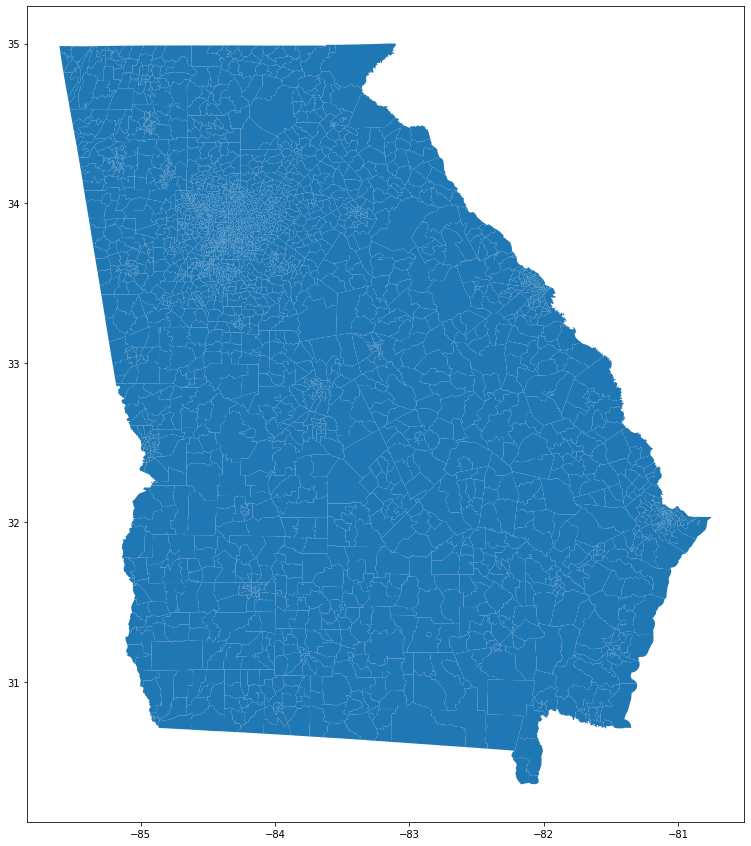

In [32]:
vtd2016.plot(figsize=(15,15))